# Stochastic SEAI5R model


In the present notebook, we consider the stochastic SEAI5R model.

We generate 100 realisations of the stochastic dynamics, and visualise them together with mean, standard deviation, median, and 10- as well as 90-percent quantiles.

In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

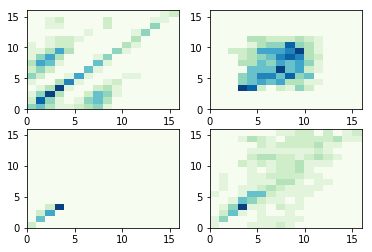

In [3]:
# contact matrices
my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_home_2.xlsx', sheet_name='United Kingdom of Great Britain')
CH0 = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_work_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CW0 = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_school_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CS0 = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_other_locations_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CO0 = np.array(my_data)

CH = np.zeros((16, 16))
CH[0,:]= np.array((0.478812799633172, 0.55185413960287,0.334323605154544,0.132361228266194,0.138531587861408,0.281604887066586,0.406440258772792,0.493947983343078,0.113301080935514,0.0746826413664804,0.0419640342896305,0.0179831987029717,0.00553694264516568,0.00142187285266089,0,0.000505582193632659))
for i in range(15):
    CH[i+1, :] = CH0[i, :]

    
CW = np.zeros((16, 16))
CW[0,:]= np.array((0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000820604524144799,0.0000120585150153575,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000316436833811157))
for i in range(15):
    CW[i+1, :] = CW0[i, :]

    
CS = np.zeros((16, 16))
CS[0,:]= np.array((0.974577996106766,0.151369805263473,0.00874880925953218,0.0262790907947637,0.0111281607429249,0.0891043051294382,0.125477587043249,0.0883182775274553,0.0371824197201174,0.0294092695284747,0.0000000000000000000000000000000000000510911446027435,0.0000000000000000000000000000000113982464440009,0.00758428705895781,0.00151636767747242,0.0000000000000000000000000000000000000000000000000123262013953524,0.000000000000000000000000000000000000000000000000000000000000000597486362181075))
for i in range(15):
    CS[i+1, :] = CS0[i, :]

CO = np.zeros((16, 16))
CO[0,:]= np.array((0.257847576361162,0.100135168376607,0.0458036773638843,0.127084549151753,0.187303683093508,0.257979214509792,0.193228849121415,0.336594916946786,0.309223290169635,0.070538522966953,0.152218422246435,0.113554851510519,0.0615771477785246,0.040429874099682,0.0373564987094767,0.00669781557624776))
for i in range(15):
    CO[i+1, :] = CO0[i, :]

## matrix of total contacts
C=CH+CW+CS+CO



fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

In [4]:
beta  = 0.036692            # infection rate 

gE    = 1/5
gA    = 1/3
gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.3                 # fraction of asymptomatic infectives 
fsa   = 0.2                   # the self-isolation parameter   
fh    = 0
gIh   = 1/14
gIc   = 1/14
 
sa    = 100*np.ones(M)      # arrival of new susceptibles
sa[0] = 1500


hh   = 0.1*np.ones(M)
cc   = 0.05*np.ones(M)      
mm   = 0.4*np.ones(M)      






# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4

Ia_0 = np.zeros((M));  Ia_0[6:13]=4;  Ia_0[2:6]=2; Ia_0[13:16]=2
R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (Ia_0 + Is_0 + R_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (1.319908017634234+0j)


0.0

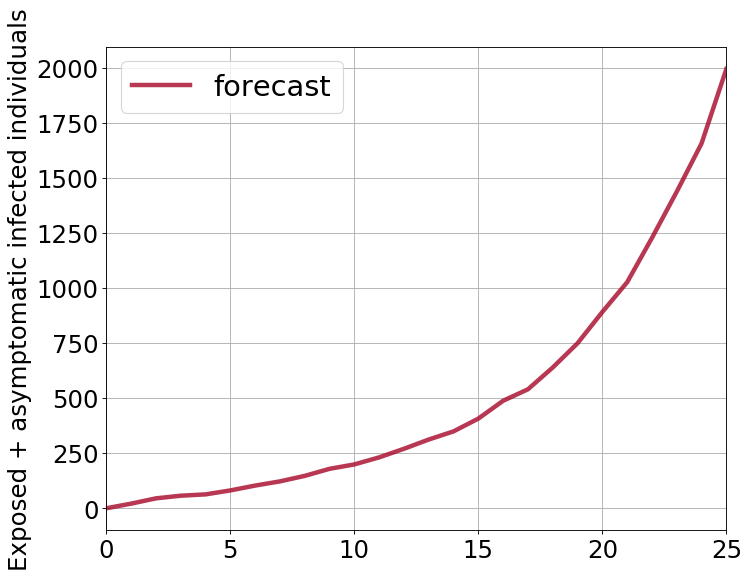

In [7]:
# duration of simulation and data file
Tf=25;  Nf=Tf+1;  



# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEAI5R(parameters, M, Ni)



# the contact structure is independent of time 
def contactMatrix(t):
    return C
# run model
data=model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)


t = data['t']; IC  = np.zeros((Nf))
for i in range(2*M):
        IC += data['X'][:,M+i]
        

        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)

 
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Exposed + asymptomatic infected individuals'); #plt.xlim(0, 40); plt.ylim(0, 9999);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)
IC[0]

Since the stochastic SEAI5R model is used here, a different trajectory will result every time the above cell is run.

## Averaging over several realisations

We now run 100 simulations, and plot the resulting trajectories together with mean, standard deviations, and quantiles.

In [10]:
# run 100 simulations
N_runs = 100


model = pyross.stochastic.SEAI5R(parameters, M, Ni)
trajectories_s = np.zeros([N_runs,Nf,9*M],dtype=float)
for i in range(N_runs):
    print('Running simulation {0} of {1}'.format(i+1,N_runs),end='\r')
    cur_result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)
    trajectories_s[i] = cur_result['X']
t_s = cur_result['t']

In [11]:
# Calculate mean, standard deviation, and 10 as well as 90 percent quantiles
# for
# - the number of exposed and asymptomatic infectives,
# - the number of symptomatic infectives,
# - the number of hospitalised infectives,
# - the number of infectives in ICU,
# - the number of deceased infectives

trajectories_E_A_Ia = np.zeros([N_runs,Nf],dtype=float)
trajectories_Is = np.zeros([N_runs,Nf],dtype=float)
trajectories_Ih = np.zeros([N_runs,Nf],dtype=float)
trajectories_Ic = np.zeros([N_runs,Nf],dtype=float)
trajectories_Im = np.zeros([N_runs,Nf],dtype=float)
for i,e in enumerate(trajectories_s):
    for j in range(M):
        trajectories_E_A_Ia[i] += e[:,j+1*M] + e[:,j+2*M] + e[:,j+3*M] # E + A + Ia
        trajectories_Is[i] += e[:,j+3*M] # Is
        trajectories_Ih[i] += e[:,j+4*M] # Ih
        trajectories_Ic[i] += e[:,j+5*M] # Ic
        trajectories_Im[i] += e[:,j+6*M] # Im

        
# mean and standard deviation
mean_E_A_Ia = np.mean(trajectories_E_A_Ia, axis = 0)
mean_Is = np.mean(trajectories_Is, axis = 0)
mean_Ih = np.mean(trajectories_Ih, axis = 0)
mean_Ic = np.mean(trajectories_Ic, axis = 0)
mean_Im = np.mean(trajectories_Im, axis = 0)

std_E_A_Ia = np.std(trajectories_E_A_Ia, axis = 0)
std_Is = np.std(trajectories_Is, axis = 0)
std_Ih = np.std(trajectories_Ih, axis = 0)
std_Ic = np.std(trajectories_Ic, axis = 0)
std_Im = np.std(trajectories_Im, axis = 0)


# quantiles
percentile = 10

cur_traj = trajectories_E_A_Ia
percentiles_lower_E_A_Ia = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_E_A_Ia = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_E_A_Ia = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Is
percentiles_lower_Is = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Is = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Is = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Ih
percentiles_lower_Ih = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Ih = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Ih = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Ic
percentiles_lower_Ic = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Ic = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Ic = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Im
percentiles_lower_Im = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Im = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Im = np.percentile(cur_traj,50,axis=0)

## Plot of results from 100 stochastic simulations

In [12]:
def plot_data(t,trajectories,mean,std,median,percentiles_lower,percentiles_upper,
             ylabel='Population'):
    #
    # Trajectories + mean and standard deviation
    #
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle('Trajectories, with mean and standard deviation')
    ax.fill_between(t,mean-std,mean+std,
                    color='red',alpha=0.1
                   )
    for i,e in enumerate(trajectories):
        ax.plot(t,e,
               alpha=0.3)
    ax.plot(t,mean,lw=3,color='black',label='Mean')
    ax.plot(t,mean+std,lw=2,ls='--',color='red',label='Standard deviation')
    ax.plot(t,mean-std,lw=2,ls='--',color='red')
    ax.set_xlim(np.min(t_s),np.max(t_s))
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    plt.show(fig)
    plt.close(fig)
    #
    #
    # Trajectories + percentiles
    #
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle('Trajectories, with quantiles')
    ax.fill_between(t,percentiles_lower,percentiles_upper,
                    color='red',alpha=0.1
                   )
    for i,e in enumerate(trajectories):
        ax.plot(t,e,
               alpha=0.3)
    ax.plot(t,median,lw=3,color='black',
           label='Median')
    ax.plot(t,mean,lw=3,color='dodgerblue',ls='--',
           label='Mean')
    ax.plot(t,percentiles_lower,lw=2,ls='--',color='red',
           label='Quantiles')
    ax.plot(t,percentiles_upper,lw=2,ls='--',color='red')
    ax.set_xlim(np.min(t_s),np.max(t_s))
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    plt.show(fig)
    plt.close(fig)

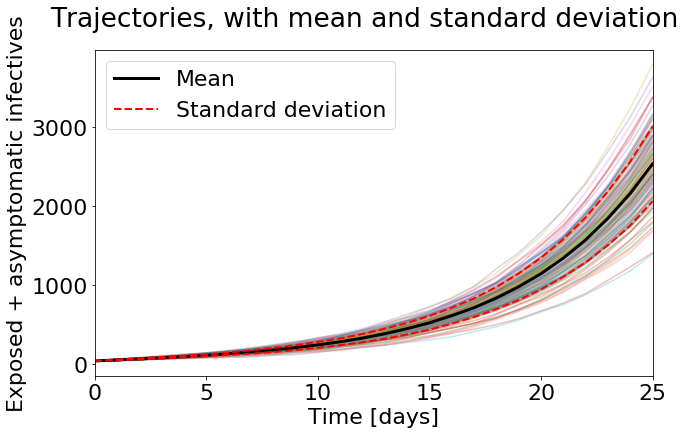

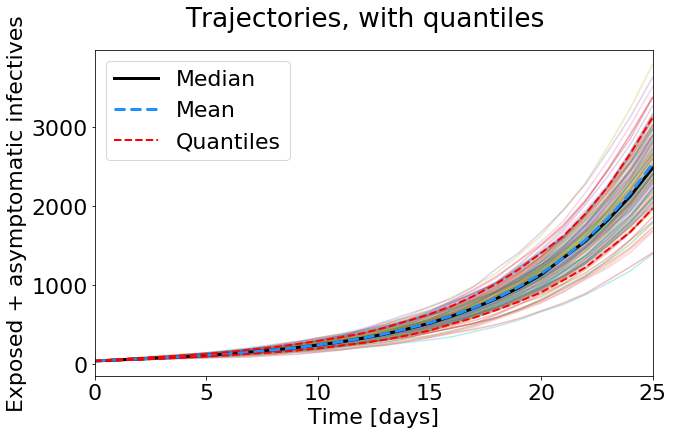

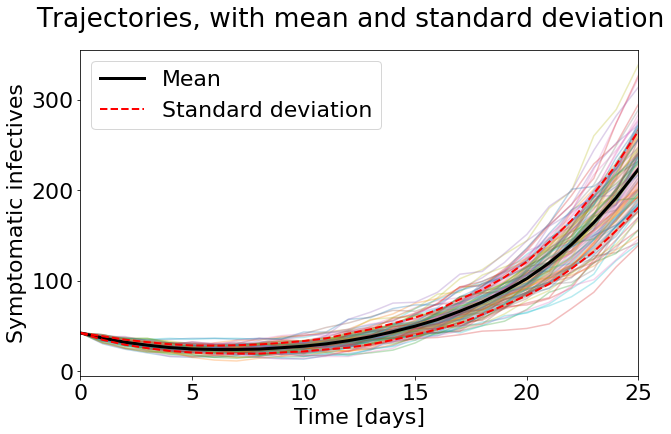

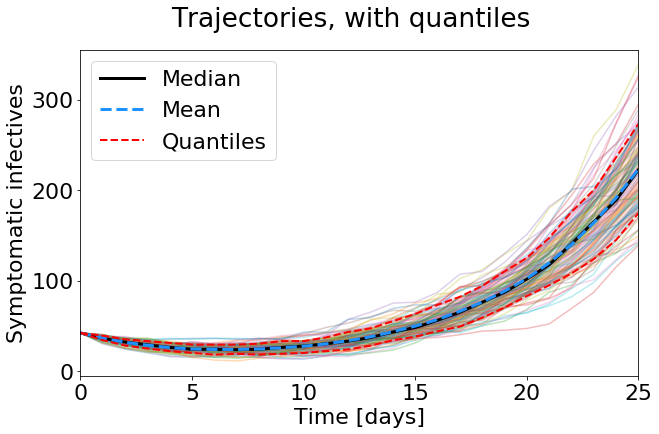

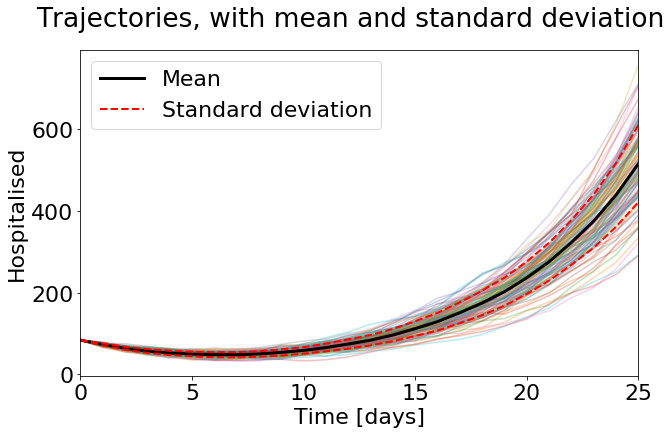

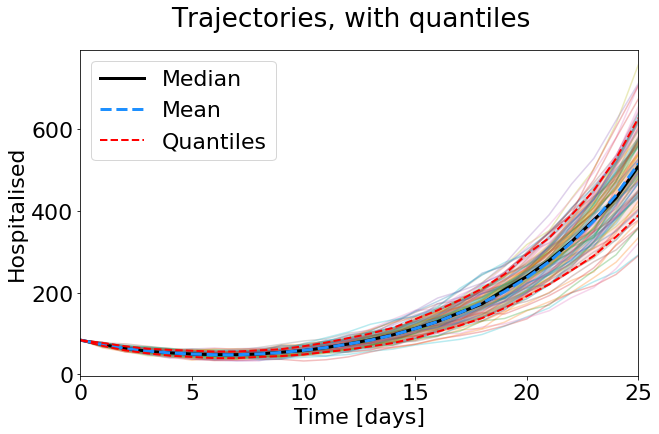

In [13]:
plot_data(t_s,
          trajectories = trajectories_E_A_Ia,
          mean = mean_E_A_Ia,  std =std_E_A_Ia,
         median = percentiles_median_E_A_Ia, 
          percentiles_lower =percentiles_lower_E_A_Ia, percentiles_upper =percentiles_upper_E_A_Ia,
         ylabel=r'Exposed + asymptomatic infectives')


print("\n\n")
plot_data(t_s,
          trajectories = trajectories_Is,
          mean = mean_Is,  std =std_Is,
         median = percentiles_median_Is, 
          percentiles_lower =percentiles_lower_Is, percentiles_upper =percentiles_upper_Is,
         ylabel=r'Symptomatic infectives')


print("\n\n")
plot_data(t_s,
          trajectories = trajectories_Ih,
          mean = mean_Ih,  std =std_Ih,
         median = percentiles_median_Ih, 
          percentiles_lower =percentiles_lower_Ih, percentiles_upper =percentiles_upper_Ih,
         ylabel=r'Hospitalised')